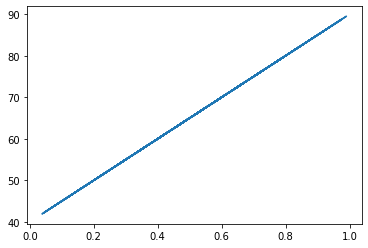

In [5]:
import numpy as np
import matplotlib.pyplot as plt

X = np.random.rand(100).astype(np.float32)
a = 50
b = 40
Y = a*X+b
plt.plot(X,Y)

5.0


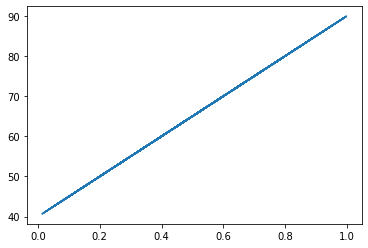

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
tf.__version__

v1 = tf.Variable(0.0)
p1 = tf.placeholder(tf.float32)
new_val = tf.add(v1, p1)
update = tf.assign(v1, new_val)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for _ in range(5):
        sess.run(update, feed_dict={p1: 1.0})
    print(sess.run(v1))
    
X = np.random.rand(100).astype(np.float32)
a = 50
b = 40
Y = a*X+b
plt.plot(X, Y);

    school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
128     GP   M   18       R     GT3       T     2     2  services     other   
161     GP   M   15       R     GT3       T     3     2     other     other   
162     GP   M   16       U     LE3       T     1     2     other     other   
163     GP   M   17       U     GT3       T     1     3   at_home  services   
165     GP   M   16       U     GT3       T     3     2  services  services   
..     ...  ..  ...     ...     ...     ...   ...   ...       ...       ...   
391     MS   M   17       U     LE3       T     3     1  services  services   
393     MS   M   18       R     LE3       T     3     2  services     other   
424     MS   F   16       R     GT3       T     2     2     other     other   
442     MS   M   15       R     LE3       T     4     1    health  services   
453     MS   F   16       U     GT3       T     1     2     other  services   

     ... freetime goout  Dalc  Walc  health absence

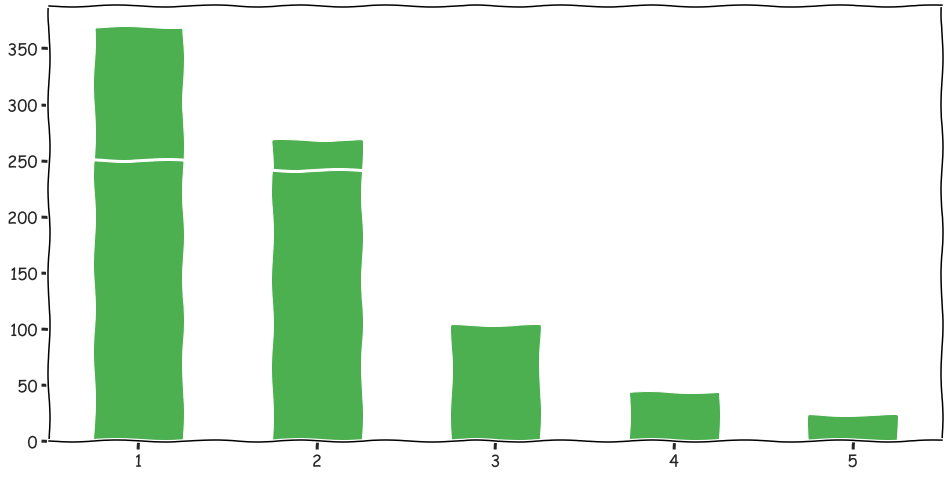

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from math import floor, ceil
from pylab import rcParams

%matplotlib inline

sns.set(style='ticks', palette='Spectral', font_scale=1.5)

material_palette = ["#4CAF50", "#2196F3", "#9E9E9E", "#FF9800", "#607D8B", "#9C27B0"]
sns.set_palette(material_palette)
rcParams['figure.figsize'] = 16, 8

plt.xkcd();
random_state = 42
np.random.seed(random_state)
tf.set_random_seed(random_state)

math_df = pd.read_csv("data/student/student-mat.csv", sep=";")
port_df = pd.read_csv("data/student/student-por.csv", sep=";")

math_df["course"] = "math"
port_df["course"] = "portuguese"

merged_df = math_df.append(port_df)
merged_df.shape

merge_vector = ["school","sex","age","address",
                "famsize","Pstatus","Medu","Fedu",
                "Mjob","Fjob","reason","nursery","internet"]

duplicated_mask = merged_df.duplicated(keep=False, subset=merge_vector)
duplicated_df = merged_df[duplicated_mask]
unique_df = merged_df[~duplicated_mask]
both_courses_mask = duplicated_df.duplicated(subset=merge_vector)
both_courses_df = duplicated_df[~both_courses_mask].copy()
both_courses_df["course"] = "both"
students_df = unique_df.append(both_courses_df)
students_df.shape
print(students_df)

students_df = students_df.sample(frac=1)
students_df['alcohol'] = (students_df.Walc * 2 + students_df.Dalc * 5) / 7
students_df['alcohol'] = students_df.alcohol.map(lambda x: ceil(x))
students_df['drinker'] = students_df.alcohol.map(lambda x: "yes" if x > 2 else "no")

students_df.course.value_counts().plot(kind="bar", rot=0);

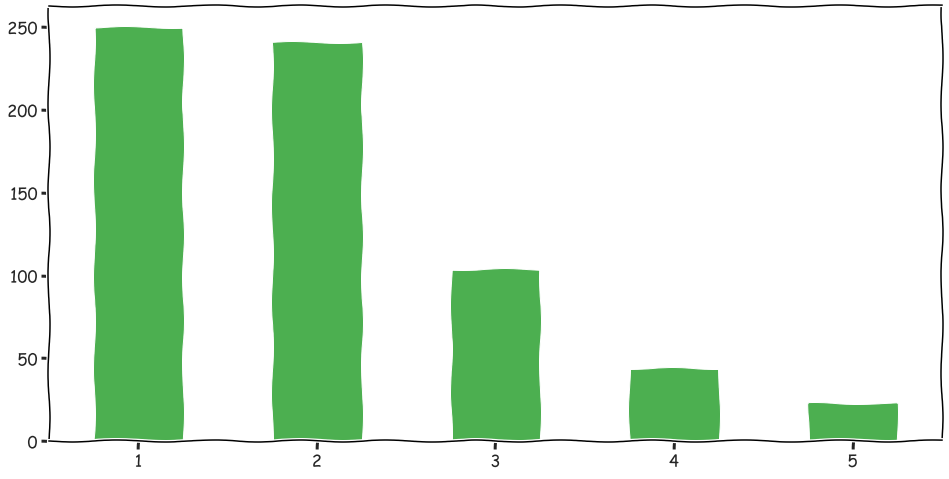

In [23]:
students_df.alcohol.value_counts().plot(kind="bar", rot=0);

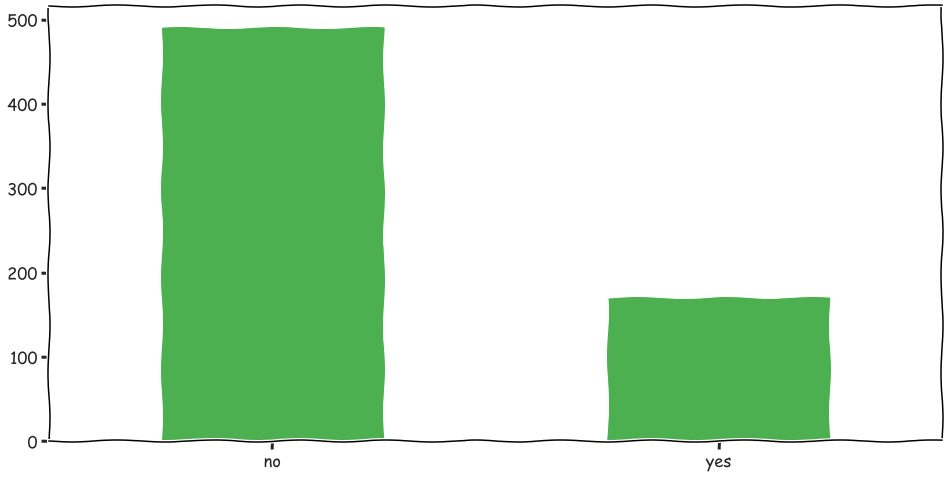

In [24]:
students_df.drinker.value_counts().plot(kind="bar", rot=0);

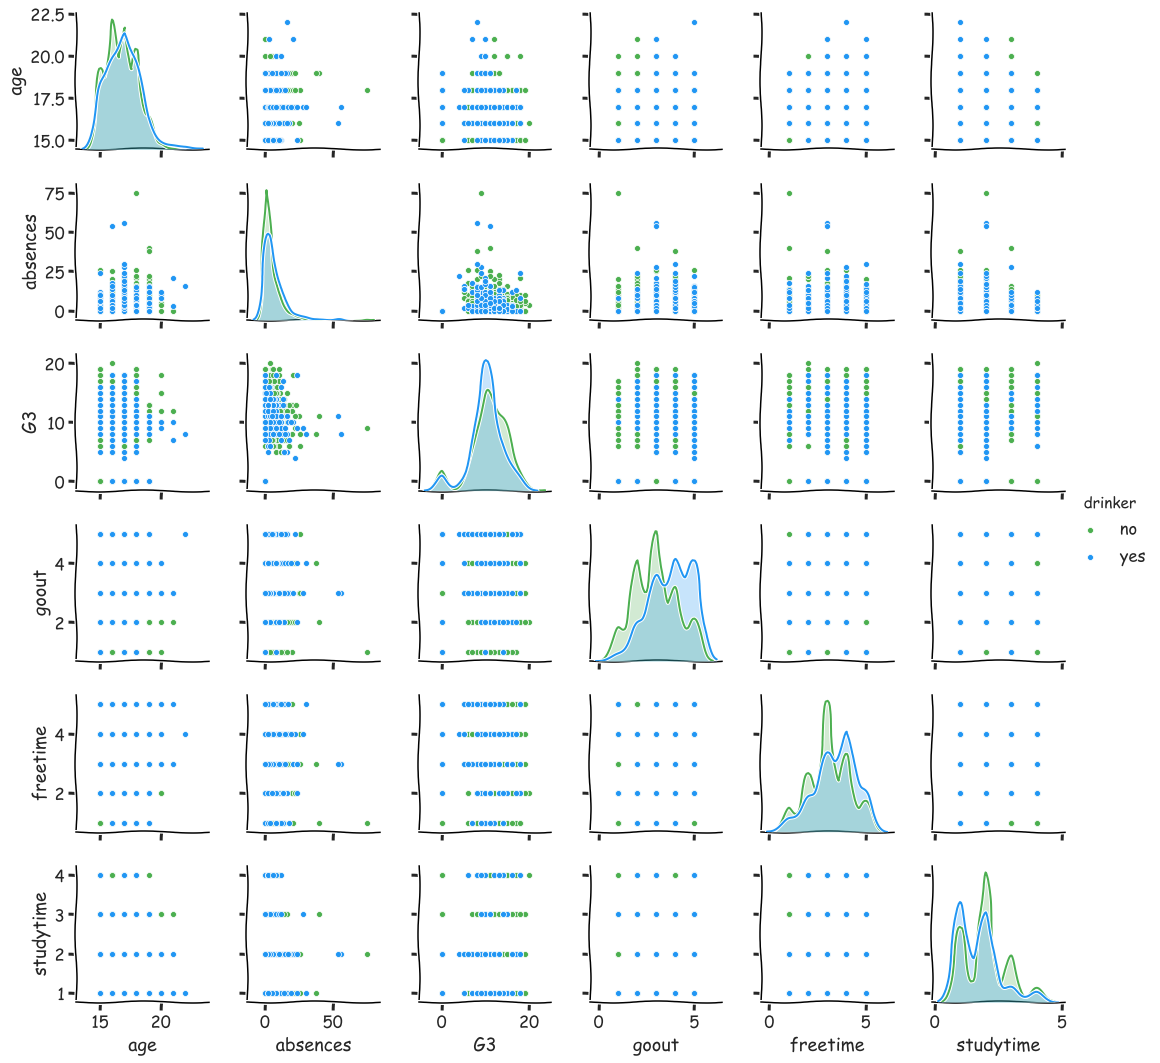

In [25]:
sns.pairplot(students_df[['age', 'absences', 'G3', 'goout', 'freetime', 'studytime', 'drinker']], hue='drinker');

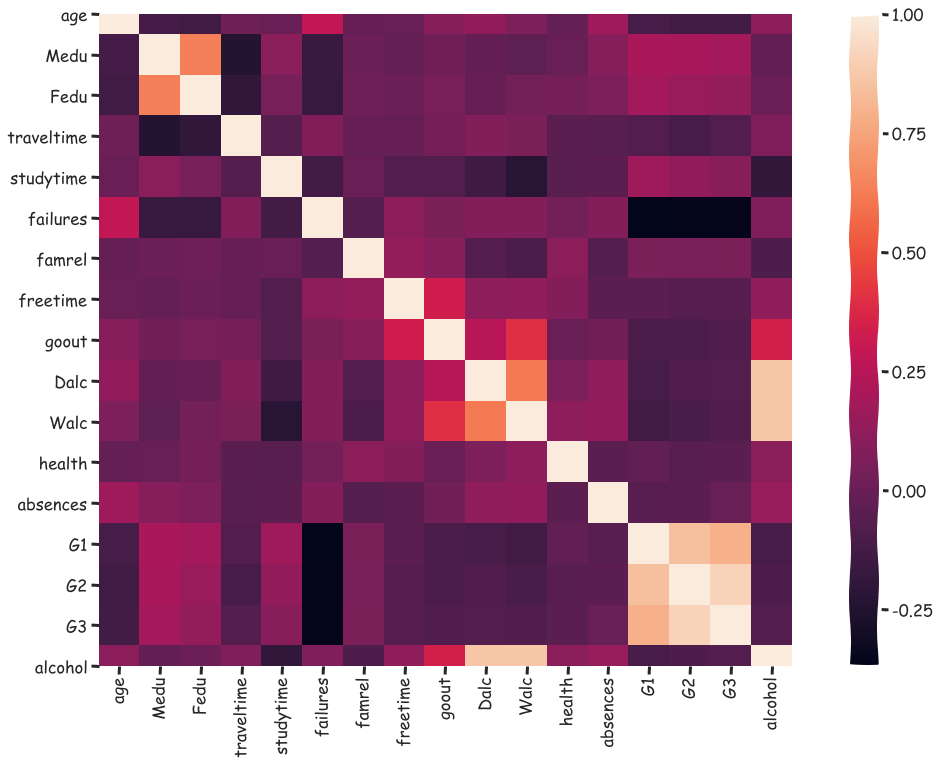

In [28]:
corr_mat = students_df.corr() 
fig, ax = plt.subplots(figsize=(20, 12)) 
sns.heatmap(corr_mat, vmax=1.0, square=True, ax=ax);

In [35]:
def encode(series): 
  return pd.get_dummies(series.astype(str))

train_x = pd.get_dummies(students_df.school)
train_x['age'] = students_df.age
train_x['absences'] = students_df.absences
train_x['g1'] = students_df.G1
train_x['g2'] = students_df.G2
train_x['g3'] = students_df.G3
train_x = pd.concat([train_x, encode(students_df.sex), encode(students_df.Pstatus), 
                     encode(students_df.Medu), encode(students_df.Fedu),
                     encode(students_df.guardian), encode(students_df.studytime),
                     encode(students_df.failures), encode(students_df.activities),
                     encode(students_df.higher), encode(students_df.romantic),
                     encode(students_df.reason), encode(students_df.paid),
                     encode(students_df.goout), encode(students_df.health),
                     encode(students_df.famsize), encode(students_df.course)
                    ], axis=1)

train_y = encode(students_df.drinker)

train_size = 0.9

train_cnt = floor(train_x.shape[0] * train_size)
x_train = train_x.iloc[0:train_cnt].values
y_train = train_y.iloc[0:train_cnt].values
x_test = train_x.iloc[train_cnt:].values
y_test = train_y.iloc[train_cnt:].values

def multilayer_perceptron(x, weights, biases, keep_prob):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_1 = tf.nn.dropout(layer_1, keep_prob)
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer

n_hidden_1 = 38
n_input = train_x.shape[1]
n_classes = train_y.shape[1]

weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_hidden_1, n_classes]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

keep_prob = tf.placeholder("float")

training_epochs = 5000
display_step = 1000
batch_size = 32

x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])
predictions = multilayer_perceptron(x, weights, biases, keep_prob)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictions, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(training_epochs):
        avg_cost = 0.0
        total_batch = int(len(x_train) / batch_size)
        x_batches = np.array_split(x_train, total_batch)
        y_batches = np.array_split(y_train, total_batch)
        for i in range(total_batch):
            batch_x, batch_y = x_batches[i], y_batches[i]
            _, c = sess.run([optimizer, cost], 
                            feed_dict={
                                x: batch_x, 
                                y: batch_y, 
                                keep_prob: 0.8
                            })
            avg_cost += c / total_batch
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", \
                "{:.9f}".format(avg_cost))
    print("Optimization Finished!")
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval({x: x_test, y: y_test, keep_prob: 1.0}))


Epoch: 0001 cost= 95.137824164
Epoch: 1001 cost= 2.747433066
Epoch: 2001 cost= 0.463768425
Epoch: 3001 cost= 0.304738491
Epoch: 4001 cost= 0.230859044
Optimization Finished!
Accuracy: 0.6567164
